In [9]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# Load CIFAR-10 dataset
cifar10_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_testset = datasets.CIFAR10(root='./data', train=False, transform=transform)

Files already downloaded and verified


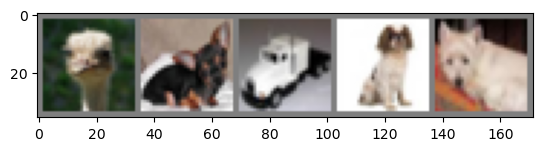

In [10]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(DataLoader(cifar10_trainset, batch_size=5, shuffle=True))
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [11]:
train_size = int(0.9 * len(cifar10_trainset))
val_size = len(cifar10_trainset) - train_size
cifar10_train, cifar10_val = random_split(cifar10_trainset, [train_size, val_size])

train_loader = DataLoader(cifar10_train, batch_size=32, shuffle=True)
val_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False)

In [12]:
class SimResNet(nn.Module):
    def __init__(self):
        super(SimResNet, self).__init__()
        original_resnet = resnet18(pretrained=True)
        self.features = nn.Sequential(*list(original_resnet.children())[:-4])  
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = SimResNet()
model.to(device)

SimResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

Epoch 1 training loss: 0.9492816785674784
Epoch 1 validation loss: 0.7135576949377728
Epoch 2 training loss: 0.6500578084014033
Epoch 2 validation loss: 0.6633461609387853
Epoch 3 training loss: 0.5322122101505852
Epoch 3 validation loss: 0.5804341511361918
Epoch 4 training loss: 0.4382065784109342
Epoch 4 validation loss: 0.5825890023617228
Epoch 5 training loss: 0.365603024485523
Epoch 5 validation loss: 0.5589703520297244
Epoch 6 training loss: 0.30187021593305774
Epoch 6 validation loss: 0.5919009899827326
Epoch 7 training loss: 0.2405342743550007
Epoch 7 validation loss: 0.6552486322867642
Epoch 8 training loss: 0.20036921813467143
Epoch 8 validation loss: 0.6670916582558565
Epoch 9 training loss: 0.16737494555943366
Epoch 9 validation loss: 0.7285755384879508
Epoch 10 training loss: 0.14565141317477634
Epoch 10 validation loss: 0.7247514293357066
Epoch 11 training loss: 0.12805185755800824
Epoch 11 validation loss: 0.7519104760733379
Epoch 12 training loss: 0.11110932800710975
Ep

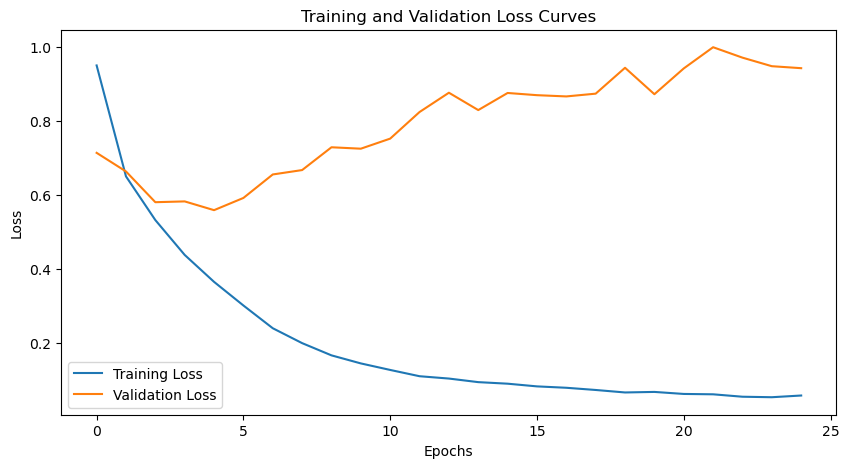

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(25):  
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1} training loss: {running_loss / len(train_loader)}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    print(f'Epoch {epoch + 1} validation loss: {val_loss / len(val_loader)}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct / total}%')

test_loader = DataLoader(cifar10_testset, batch_size=32, shuffle=False)
predictions = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())

print(predictions[:10])

Accuracy of the network on the validation images: 81.06%
[3, 8, 8, 8, 6, 6, 1, 6, 3, 1]
